In [1]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [2]:
filePath = "gs://dataproc-staging-us-east1-484410736875-hru3bcdb/Pokemon.csv"

# Read in file
df = spark.read.format('com.databricks.spark.csv').\
                       options(header='true', \
                       inferschema='true').\
            load(filePath,header=True);

# Rename columns for easy access
df = df.withColumnRenamed("Type 1", "Type_1") \
       .withColumnRenamed("Type 2", "Type_2") \
       .withColumnRenamed("Sp. Atk", "Sp_Atk") \
       .withColumnRenamed("Sp. Def", "Sp_Def")
df.show(5,True)
df.printSchema()

+---+--------------------+------+------+-----+---+------+-------+------+------+-----+----------+---------+
|  #|                Name|Type_1|Type_2|Total| HP|Attack|Defense|Sp_Atk|Sp_Def|Speed|Generation|Legendary|
+---+--------------------+------+------+-----+---+------+-------+------+------+-----+----------+---------+
|  1|           Bulbasaur| Grass|Poison|  318| 45|    49|     49|    65|    65|   45|         1|    false|
|  2|             Ivysaur| Grass|Poison|  405| 60|    62|     63|    80|    80|   60|         1|    false|
|  3|            Venusaur| Grass|Poison|  525| 80|    82|     83|   100|   100|   80|         1|    false|
|  3|VenusaurMega Venu...| Grass|Poison|  625| 80|   100|    123|   122|   120|   80|         1|    false|
|  4|          Charmander|  Fire|  NULL|  309| 39|    52|     43|    60|    50|   65|         1|    false|
+---+--------------------+------+------+-----+---+------+-------+------+------+-----+----------+---------+
only showing top 5 rows

root
 |-- #:

In [14]:
import pandas as pd
disp_data = df.select("Total", "HP", "Attack", "Defense", "Sp_Atk", "Sp_Def", "Speed", "Generation").describe()
disp_data.toPandas().style.hide()

summary,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation
count,800,800,800,800,800,800,800,800
mean,435.1025,69.25875,79.00125,73.8425,72.82,71.9025,68.2775,3.32375
stddev,119.96303975551908,25.534669032332076,32.45736586949845,31.183500559332924,32.7222941688016,27.82891579711746,29.060473717161447,1.6612904004849451
min,180,1,5,5,10,20,5,1
max,780,255,190,230,194,230,180,6


In [3]:
# Convert the data to vectors
from pyspark.ml.feature import VectorAssembler
vecAssembler = VectorAssembler(inputCols=["HP", "Attack", "Defense", "Sp_Atk", "Sp_Def", "Speed"], outputCol="features")
dataset = vecAssembler.transform(df)
dataset.select("Type_1", "features").show(10)

+------+--------------------+
|Type_1|            features|
+------+--------------------+
| Grass|[45.0,49.0,49.0,6...|
| Grass|[60.0,62.0,63.0,8...|
| Grass|[80.0,82.0,83.0,1...|
| Grass|[80.0,100.0,123.0...|
|  Fire|[39.0,52.0,43.0,6...|
|  Fire|[58.0,64.0,58.0,8...|
|  Fire|[78.0,84.0,78.0,1...|
|  Fire|[78.0,130.0,111.0...|
|  Fire|[78.0,104.0,78.0,...|
| Water|[44.0,48.0,65.0,5...|
+------+--------------------+
only showing top 10 rows



In [4]:
import numpy as np
cost = np.zeros(20)
for k in range(2,19):
    # Train model
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features").setPredictionCol("cluster")
    model = kmeans.fit(dataset)
    
    # Make prediction
    predictions = model.transform(dataset)
    
    # Evaluate
    evaluator = ClusteringEvaluator(predictionCol="cluster")
    cost[k] = evaluator.evaluate(predictions)
    print("Silhouette with squared euclidean distance = " + str(cost[k]))
    

Silhouette with squared euclidean distance = 0.4382470691608637


Silhouette with squared euclidean distance = 0.4015228605174056
Silhouette with squared euclidean distance = 0.367556451062971
Silhouette with squared euclidean distance = 0.35727950682825865
Silhouette with squared euclidean distance = 0.3304389405475277
Silhouette with squared euclidean distance = 0.260565462319926
Silhouette with squared euclidean distance = 0.30336897027824444
Silhouette with squared euclidean distance = 0.26232700155621363
Silhouette with squared euclidean distance = 0.2647205919277444
Silhouette with squared euclidean distance = 0.25128660442416334
Silhouette with squared euclidean distance = 0.2572742855946867
Silhouette with squared euclidean distance = 0.23907420574867802
Silhouette with squared euclidean distance = 0.24349674499988605
Silhouette with squared euclidean distance = 0.2597134014843402
Silhouette with squared euclidean distance = 0.25355882622301007
Silhouette with squared euclidean distance = 0.2555179021873751
Silhouette with squared euclidean d

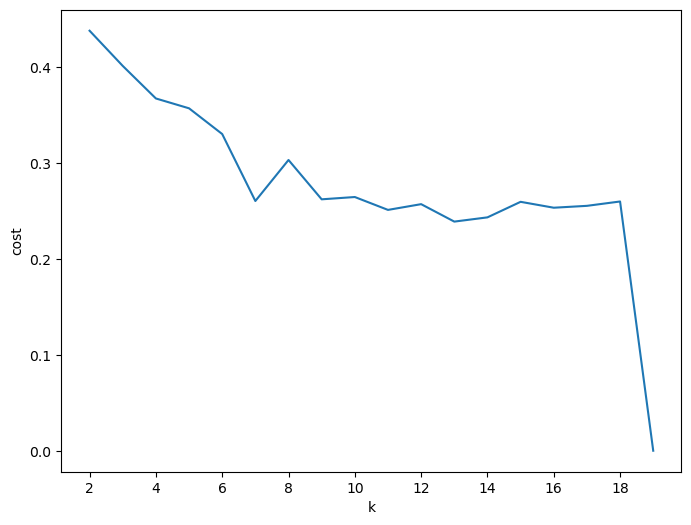

In [5]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sbs
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()
# Showing plot (what number of clusters are ideal)

In [11]:
# Choose optimal k = 6 (6 clusters)
kmeans = KMeans().setK(6).setSeed(1).setFeaturesCol("features").setPredictionCol("cluster")
model = kmeans.fit(dataset)

cluster = model.transform(dataset)
fin_cluster = cluster.select("Type_1", "HP", "Attack", "Defense", "Sp_Atk", "Sp_Def", "Speed", "Generation", "Legendary", "cluster")
fin_cluster.show(10)

+------+---+------+-------+------+------+-----+----------+---------+-------+
|Type_1| HP|Attack|Defense|Sp_Atk|Sp_Def|Speed|Generation|Legendary|cluster|
+------+---+------+-------+------+------+-----+----------+---------+-------+
| Grass| 45|    49|     49|    65|    65|   45|         1|    false|      0|
| Grass| 60|    62|     63|    80|    80|   60|         1|    false|      5|
| Grass| 80|    82|     83|   100|   100|   80|         1|    false|      2|
| Grass| 80|   100|    123|   122|   120|   80|         1|    false|      2|
|  Fire| 39|    52|     43|    60|    50|   65|         1|    false|      0|
|  Fire| 58|    64|     58|    80|    65|   80|         1|    false|      5|
|  Fire| 78|    84|     78|   109|    85|  100|         1|    false|      2|
|  Fire| 78|   130|    111|   130|    85|  100|         1|    false|      3|
|  Fire| 78|   104|     78|   159|   115|  100|         1|    false|      3|
| Water| 44|    48|     65|    50|    64|   43|         1|    false|      0|

In [12]:
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[50.025      53.46785714 52.08571429 48.06785714 49.43928571 49.04642857]
[ 94.28333333 100.53333333  78.05833333  68.99166667  72.425
  58.74166667]
[ 81.49056604  73.27358491  82.73584906 110.79245283 103.30188679
  83.32075472]
[ 90.5125 135.0875  94.4125 119.8     94.325   98.7   ]
[ 65.37142857  85.54285714 134.4         64.61428571  93.24285714
  48.88571429]
[66.88194444 80.58333333 65.22222222 74.07638889 69.20138889 95.06944444]


In [13]:
# Write to csv
csv_filepath = 'gs://dataproc-staging-us-east1-484410736875-hru3bcdb/clusters.csv'
fin_cluster.write.mode("overwrite").format("csv").save(csv_filepath)
spark.read.format('csv').load(csv_filepath).show(10)

+-----+---+---+---+---+---+---+---+-----+---+
|  _c0|_c1|_c2|_c3|_c4|_c5|_c6|_c7|  _c8|_c9|
+-----+---+---+---+---+---+---+---+-----+---+
|Grass| 45| 49| 49| 65| 65| 45|  1|false|  0|
|Grass| 60| 62| 63| 80| 80| 60|  1|false|  5|
|Grass| 80| 82| 83|100|100| 80|  1|false|  2|
|Grass| 80|100|123|122|120| 80|  1|false|  2|
| Fire| 39| 52| 43| 60| 50| 65|  1|false|  0|
| Fire| 58| 64| 58| 80| 65| 80|  1|false|  5|
| Fire| 78| 84| 78|109| 85|100|  1|false|  2|
| Fire| 78|130|111|130| 85|100|  1|false|  3|
| Fire| 78|104| 78|159|115|100|  1|false|  3|
|Water| 44| 48| 65| 50| 64| 43|  1|false|  0|
+-----+---+---+---+---+---+---+---+-----+---+
only showing top 10 rows



In [4]:
# Making a cluster of k=19 despite evaluation to see if match by typings
kmeans = KMeans().setK(19).setSeed(1).setFeaturesCol("features").setPredictionCol("cluster")
model = kmeans.fit(dataset)

cluster = model.transform(dataset)
fin_cluster = cluster.select("Type_1", "HP", "Attack", "Defense", "Sp_Atk", "Sp_Def", "Speed", "Generation", "Legendary", "cluster")
fin_cluster.show(10)

+------+---+------+-------+------+------+-----+----------+---------+-------+
|Type_1| HP|Attack|Defense|Sp_Atk|Sp_Def|Speed|Generation|Legendary|cluster|
+------+---+------+-------+------+------+-----+----------+---------+-------+
| Grass| 45|    49|     49|    65|    65|   45|         1|    false|      5|
| Grass| 60|    62|     63|    80|    80|   60|         1|    false|      2|
| Grass| 80|    82|     83|   100|   100|   80|         1|    false|     14|
| Grass| 80|   100|    123|   122|   120|   80|         1|    false|     14|
|  Fire| 39|    52|     43|    60|    50|   65|         1|    false|     18|
|  Fire| 58|    64|     58|    80|    65|   80|         1|    false|     15|
|  Fire| 78|    84|     78|   109|    85|  100|         1|    false|     14|
|  Fire| 78|   130|    111|   130|    85|  100|         1|    false|     13|
|  Fire| 78|   104|     78|   159|   115|  100|         1|    false|     14|
| Water| 44|    48|     65|    50|    64|   43|         1|    false|      5|

In [10]:
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[50.45454545 69.27272727 84.94545455 42.34545455 52.72727273 36.03636364]
[ 59.84210526  66.31578947 140.57894737  65.52631579 139.78947368
  42.15789474]
[67.44444444 64.01587302 73.80952381 73.22222222 83.68253968 62.20634921]
[ 75.97142857 116.48571429  68.42857143  95.08571429  67.2
  68.37142857]
[ 76.16216216 105.         142.08108108  60.83783784  67.48648649
  49.91891892]
[53.30769231 43.21153846 53.61538462 63.82692308 62.11538462 38.30769231]
[ 89.86111111  76.55555556  86.38888889 103.58333333  95.25
  47.66666667]
[100.67857143  98.57142857 105.07142857  92.07142857 106.85714286
  93.71428571]
[ 71.32786885 104.90163934  79.75409836  54.49180328  74.50819672
  99.54098361]
[231.66666667  16.          24.33333333  47.66666667  99.33333333
  46.        ]
[ 58.35294118  52.94117647  53.47058824 109.05882353  92.11764706
 108.52941176]
[57.49333333 74.37333333 49.37333333 47.61333333 47.06666667 56.26666667]
[108.18181818 100.15909091  73.25        66.3181818

In [9]:
# Write to csv
csv_filepath = 'gs://dataproc-staging-us-east1-484410736875-hru3bcdb/clusters19.csv'
fin_cluster.write.mode("overwrite").format("csv").save(csv_filepath)
spark.read.format('csv').load(csv_filepath).show(10)

+-----+---+---+---+---+---+---+---+-----+---+
|  _c0|_c1|_c2|_c3|_c4|_c5|_c6|_c7|  _c8|_c9|
+-----+---+---+---+---+---+---+---+-----+---+
|Grass| 45| 49| 49| 65| 65| 45|  1|false|  5|
|Grass| 60| 62| 63| 80| 80| 60|  1|false|  2|
|Grass| 80| 82| 83|100|100| 80|  1|false| 14|
|Grass| 80|100|123|122|120| 80|  1|false| 14|
| Fire| 39| 52| 43| 60| 50| 65|  1|false| 18|
| Fire| 58| 64| 58| 80| 65| 80|  1|false| 15|
| Fire| 78| 84| 78|109| 85|100|  1|false| 14|
| Fire| 78|130|111|130| 85|100|  1|false| 13|
| Fire| 78|104| 78|159|115|100|  1|false| 14|
|Water| 44| 48| 65| 50| 64| 43|  1|false|  5|
+-----+---+---+---+---+---+---+---+-----+---+
only showing top 10 rows

